<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#load-and-research-data" data-toc-modified-id="load-and-research-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load and research data</a></span></li><li><span><a href="#split-train-test" data-toc-modified-id="split-train-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>split train test</a></span><ul class="toc-item"><li><span><a href="#discart-low-second" data-toc-modified-id="discart-low-second-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>discart low second</a></span></li><li><span><a href="#fill-zeros" data-toc-modified-id="fill-zeros-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>fill zeros</a></span></li></ul></li><li><span><a href="#build-datasets" data-toc-modified-id="build-datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>build datasets</a></span><ul class="toc-item"><li><span><a href="#zeros-samples" data-toc-modified-id="zeros-samples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>zeros samples</a></span></li></ul></li><li><span><a href="#train-model" data-toc-modified-id="train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>train model</a></span></li><li><span><a href="#zeros" data-toc-modified-id="zeros-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>zeros</a></span></li></ul></div>

In [1]:
import time
import pickle
import random
import librosa
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout, Conv1D, MaxPool1D, Flatten
from keras.utils import to_categorical

import matplotlib.pyplot as plt

/home/toly/projects/mipt_hack/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# load and research data

In [2]:
df = pd.read_csv('./data/data_v_7_stc/meta/fold1_train.txt', sep='\t')

In [3]:
df.columns = ['filename', 'xz1', 'xz2', 'time', 'target']

In [4]:
df.head(1)

,filename,xz1,xz2,time,target
0,background_0001_time_stretch_1.wav,office,0.0,9.87941,background


In [5]:
df['target'].value_counts()

door             2732
tool             1327
knocking_door    1324
bags              988
keyboard          980
background        899
ring              570
speech            220
Name: target, dtype: int64

In [6]:
df_train = df.sample(frac=0.9)
df_test = df[~df.index.isin(df_train.index)]

In [7]:
df_train['target'].value_counts()

door             2450
tool             1194
knocking_door    1194
bags              899
keyboard          880
background        804
ring              522
speech            193
Name: target, dtype: int64

In [8]:
targets_list = list(df['target'].unique())
targets_list.sort()
target2ind = {
    target: i
    for i, target in enumerate(targets_list)
}

# split train test

In [10]:
T = 8000 # sample size
F = 8000 # frequency

In [11]:
def build_target_samples(df_, fill_zeros=False):
    target_samples = defaultdict(list) # target -> [sample1, sample2, ...]

    for row_no, row in df_.iterrows():

        filename = './data/data_v_7_stc/audio/' + row['filename']
        data, rate = librosa.load(filename, sr=F)

        target = row['target']
        
        for i in range(0, data.shape[0] - T, T):
            sample = data[i: i + T]
            if sample.shape[0] < T:
                if fill_zeros:
                    sample = np.array(list(sample) + [0 for _ in range(T - sample.shape[0])])
                else:
                    continue
            target_samples[target].append(sample)

    for target in target_samples.keys():
        random.shuffle(target_samples[target])

    return target_samples

## discart low second

In [17]:
test_target_samples = build_target_samples(df_test)

In [24]:
with open('./data/test_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(test_target_samples))

In [22]:
train_target_samples = build_target_samples(df_train)

In [25]:
with open('./data/train_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(train_target_samples))

## fill zeros

In [12]:
test_target_samples_zeros = build_target_samples(df_test, fill_zeros=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/toly/projects/mipt_hack/data/data_v_7_stc/audio/background_0001_time_stretch_4.wav'

In [12]:
with open('./data/test_zeros_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(test_target_samples_zeros))

In [13]:
train_target_samples_zeros = build_target_samples(df_train, fill_zeros=True)

In [14]:
with open('./data/train_zeros_8000.pkl', 'wb') as f:
    f.write(pickle.dumps(train_target_samples_zeros))

# build datasets

In [2]:
with open('./data/test_8000.pkl', 'rb') as f:
    test_target_samples = pickle.loads(f.read())

In [3]:
with open('./data/train_8000.pkl', 'rb') as f:
    train_target_samples = pickle.loads(f.read())

In [13]:
def build_dataset(target_samples):
    min_n = None
    for target, samples in target_samples.items():
        if min_n is None or len(samples) < min_n:
            min_n = len(samples)
    
    x, y = [], []
    for target, samples in target_samples.items():
        x += samples[:min_n]
        y += [target2ind[target] for _ in range(min_n)]

    x = np.vstack(x)
    y = np.array(y)
    
    indices = list(range(x.shape[0]))
    random.shuffle(indices)

    x = x[indices]
    y = y[indices]
    
    return x, y

In [12]:
x_train, y_train = build_dataset(train_target_samples)
x_test, y_test = build_dataset(test_target_samples)

In [13]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

## zeros samples

In [14]:
with open('./data/test_zeros_8000.pkl', 'rb') as f:
    test_target_samples = pickle.loads(f.read())

In [15]:
with open('./data/train_zeros_8000.pkl', 'rb') as f:
    train_target_samples = pickle.loads(f.read())

In [16]:
x_train, y_train = build_dataset(train_target_samples)
x_test, y_test = build_dataset(test_target_samples)

In [17]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# train model

In [14]:
model = Sequential()
model.add(Conv1D(128, 8, strides=2, input_shape=(8000, 1)))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(64, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(32, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(16, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=20, validation_data=[x_test, to_categorical(y_test)])

Train on 27840 samples, validate on 2936 samples
Epoch 1/20
27840/27840 [==============================] - 52s 2ms/step - loss: 1.3191 - acc: 0.5261 - val_loss: 1.0176 - val_acc: 0.6488
Epoch 2/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.8782 - acc: 0.7049 - val_loss: 0.7497 - val_acc: 0.7343
Epoch 3/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.7323 - acc: 0.7542 - val_loss: 0.8068 - val_acc: 0.7170
Epoch 4/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.6350 - acc: 0.7891 - val_loss: 0.6041 - val_acc: 0.7970
Epoch 5/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.5821 - acc: 0.8060 - val_loss: 0.5791 - val_acc: 0.8055
Epoch 6/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.5434 - acc: 0.8219 - val_loss: 0.6387 - val_acc: 0.7858
Epoch 7/20
27840/27840 [==============================] - 50s 2ms/step - loss: 0.5194 - acc: 0.8314 - val_loss: 0.6048 - val_acc:

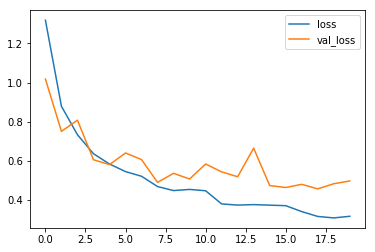

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

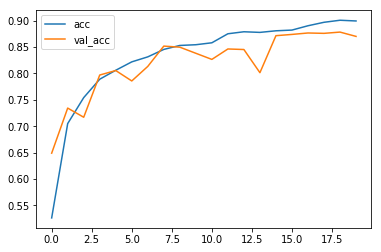

In [20]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [21]:
model.save('./data/baseline_clean1.pkl')

# zeros

In [18]:
model = Sequential()
model.add(Conv1D(128, 8, strides=2, input_shape=(8000, 1)))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(64, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(32, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(2))
model.add(Conv1D(16, 8, strides=2))
model.add(LeakyReLU())
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=20, validation_data=[x_test, to_categorical(y_test)])

Train on 27744 samples, validate on 2840 samples
Epoch 1/20
27744/27744 [==============================] - 62s 2ms/step - loss: 1.3020 - acc: 0.5362 - val_loss: 0.9522 - val_acc: 0.6620
Epoch 2/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.8554 - acc: 0.7113 - val_loss: 0.8330 - val_acc: 0.7014
Epoch 3/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.7112 - acc: 0.7627 - val_loss: 0.6897 - val_acc: 0.7648
Epoch 4/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.6132 - acc: 0.8001 - val_loss: 0.7065 - val_acc: 0.7704
Epoch 5/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.5470 - acc: 0.8212 - val_loss: 0.6950 - val_acc: 0.7739
Epoch 6/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.5133 - acc: 0.8335 - val_loss: 0.5803 - val_acc: 0.8000
Epoch 7/20
27744/27744 [==============================] - 50s 2ms/step - loss: 0.4767 - acc: 0.8465 - val_loss: 0.5412 - val_acc:

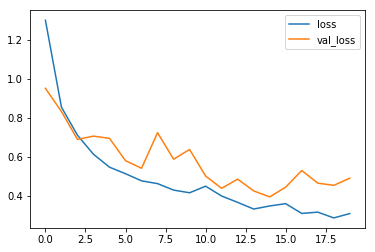

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

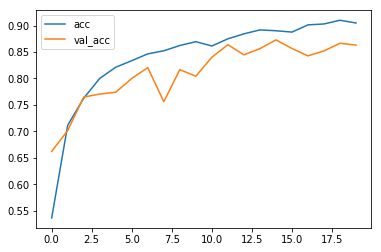

In [22]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [23]:
model.save('./data/baseline_clean_zeros1.pkl')